In [32]:
import tensorflow as tf
from numpy.random import multivariate_normal
import matplotlib.pyplot as plt
import numpy as np

import seaborn as sns

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  after removing the cwd from sys.path.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  """


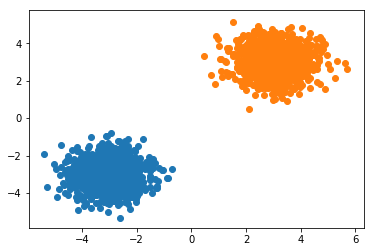

In [2]:
# GENERATE THE DATA

size = 1000
ball_0 = multivariate_normal(mean=[-3,-3], cov=[[0, 0.5], [0.5, 0] ], size=size)
ball_1 = multivariate_normal(mean=[3,3], cov=[[0, 0.5], [0.5, 0] ], size=size)

plt.scatter(ball_0[:,0], ball_0[:,1])
plt.scatter(ball_1[:,0], ball_1[:,1])
plt.show()


# 

In [3]:
y_0 = [0] * size 
y_1 = [1] * size
y = np.concatenate([y_0,y_1])[:,np.newaxis]
X = np.concatenate([ball_0, ball_1])

data = np.hstack([X,y])
data.shape

# permutate random
np.random.shuffle(data)
X = data[:,0:2]
y = data[:,2]

In [4]:
X.shape

(2000, 2)

In [5]:
y.shape

(2000,)

In [15]:
x_train = X[0:1500,:]
x_test = X[1500:,:]

y_train = y[0:1500]
y_train = y_train[:, np.newaxis]

y_test = y[1500:]
y_test = y_test[:, np.newaxis]

In [16]:
x_train.shape

(1500, 2)

In [20]:
x_test.shape

(500, 2)

In [18]:
y_test.shape

(500, 1)

In [29]:
x_tf = tf.placeholder(tf.float32, shape=(None, 2), name="x")
y_tf = tf.placeholder(tf.float32, shape=(None, 1), name="y")

linear_model = tf.layers.Dense(units=1)

y_pred = linear_model(x_tf)
loss = tf.losses.mean_squared_error(labels=y_tf, predictions=y_pred)

optimizer = tf.train.GradientDescentOptimizer(0.01)
train = optimizer.minimize(loss)

init = tf.global_variables_initializer()

sess = tf.Session()
sess.run(init)
for i in range(100):
  _, loss_value = sess.run((train, loss), feed_dict={x_tf: x_train, y_tf: y_train})
  # print(loss_value)

In [31]:
final_preds = sess.run(y_pred, feed_dict={x_tf: x_test})
final_preds = final_preds.squeeze(axis=1)
final_preds = final_preds <= 0.5


array([False,  True, False,  True,  True,  True,  True,  True, False,
       False, False,  True,  True, False,  True, False, False,  True,
       False, False,  True, False, False, False, False, False, False,
       False, False, False,  True,  True,  True,  True, False, False,
       False,  True, False,  True, False, False, False, False,  True,
        True, False, False, False, False,  True,  True,  True,  True,
        True,  True, False,  True, False, False, False,  True, False,
       False,  True, False,  True,  True,  True, False, False,  True,
       False,  True,  True, False,  True,  True,  True, False, False,
        True, False,  True,  True,  True,  True, False,  True,  True,
        True,  True, False,  True, False,  True,  True,  True,  True,
       False, False, False,  True, False,  True, False, False, False,
       False, False, False,  True, False, False, False,  True,  True,
       False, False, False,  True,  True, False,  True, False,  True,
       False, False,

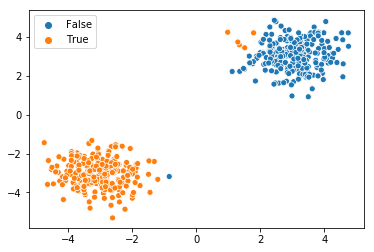

In [40]:
sns.scatterplot(x=x_test[:,0], y=x_test[:,1], hue=final_preds)
plt.show()

In [ ]:
x_grid = np